In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#switch to directory where there is a version of the dataset that is split into train,test and validation data
cd 'drive/MyDrive/Uni/UniPD/HumanDataProject/Code'

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code


In [ ]:
!pip install tensorflow-io
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import subprocess
import sys
import threading
import time
import psutil
import warnings


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras_tuner import BayesianOptimization  #, kt
from scipy.io import wavfile
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from config import DATASET_SPLIT_PATH, PREPROCESSING_PATH

In [ ]:
warnings.filterwarnings(action='ignore', category=wavfile.WavFileWarning)

In [ ]:
sys.path.append(PREPROCESSING_PATH)

In [ ]:
import evaluation
import preprocessing_tf
import conformer

In [ ]:
from conformer import ConformerBlock, FeedForwardModule, RelativePositionMultiHeadAttention, ConvolutionalModule1D

In [ ]:
print("Number of GPU:", len(tf.config.list_physical_devices('GPU')))
print("Version:", tf.__version__)

Number of GPU: 1
Version: 2.15.0


# Dataset loading

To improve training efficiency, the dataset is pre-loaded into runtime, avoiding slow read speeds from the drive. It's already divided into train, validation, and test folders.

In [ ]:

%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [ ]:
!unzip project_data_split.zip -d /content/data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/data/project_data_split/validation/off/439c84f4_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_3.wav 

In [ ]:
DATASET_SPLIT_PATH = "/content/data/project_data_split"

# Preprocessing


The preprocessing steps outlined below are used to prepare the data for the Conformer model:

*   All non-keywords are categorized into a single class named "unknown" to simplify the multi-class classification problem by reducing the number of classes.
*   Data padding is applied to ensure a consistent input shape across all samples.
*   Noise is added to enhance realism in the dataset and to avoid overfitting
*   The audio is transformed into MFCC (Mel Frequency Cepstral Coefficients) spectrograms for analysis.

In [ ]:
train_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"train"))
val_df= preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"validation"))

In [ ]:
file_paths = tf.constant(train_df['filepath'].values)
labels = tf.constant(train_df['mapped_label'].values)

In [ ]:

# Create a StringLookup layer and transform the class names to numeric labels
label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(labels)
numeric_labels = label_lookup(labels)

# Create train datatset
train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, numeric_labels))

In [ ]:
#create validation data set
file_paths_val = tf.constant(val_df['filepath'].values)
labels_val = tf.constant(val_df['mapped_label'].values)
numeric_labels_val = label_lookup(labels_val)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_paths_val, numeric_labels_val))

In [ ]:
#define which preprocessing steps should be applied
train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,noise=True, mfcc=True),
                               num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

val_spectrogram_ds = validation_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,noise=True, mfcc=True),
                               num_parallel_calls=tf.data.AUTOTUNE)

val_spectrogram_ds= val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/doing_the_dishes.wav
Noisy shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)
Padding shape: (16000,)
/content/data/project_data_split/_background_noise_/doing_the_dishes.wav
Noisy shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)


In [ ]:
#define batch size
batch_size = 32
train_spectrogram_ds = train_spectrogram_ds.batch(batch_size)
val_spectrogram_ds = val_spectrogram_ds.batch(batch_size)

In [ ]:
#check input shape and number of labels
input_shape =train_spectrogram_ds.element_spec[0].shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_lookup.get_vocabulary())
print('Number of labels:', num_labels)

Input shape: (98, 40, 1)
Number of labels: 26


# Conformer Model


A Conformer model is a hybrid neural network architecture that combines the strengths of Convolutional Neural Networks (CNNs) and Transformers to efficiently process sequential data. It is designed for capturing both local features through convolutional layers and global dependencies using self-attention mechanisms and was designed for automatic speech recognition. We follow the conformer architecture described in [Gulati20].

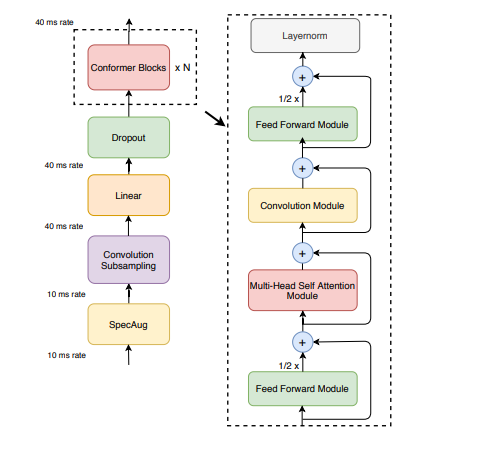



For an input x given to a Conformer block, the output y is calculated as follows

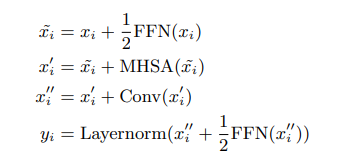


## Hyperparameter tuning

In [Gulati20], the smallest Conformer model is described as having 16 million parameters and comprising 16 Conformer blocks. Given that keyword spotting is often deployed on devices with limited memory capacity, a model with 16 million parameters would be too computationally intensive. Consequently, we aim to develop a simpler Conformer model with fewer parameters and Conformer blocks. To identify the optimal hyperparameters, we employ Bayesian optimization from Keras Tuner (https://keras.io/api/keras_tuner/tuners/bayesian/). We optimize the following hyperparameters:



*   Model dimensions (min_value=128, max_value=256, step=32)
*   Number of heads (min_value=2, max_value=8, step=2)
*   Kernel size (min_value=3, max_value=8, step=1)
*   Dropout rate (min_value=0.1, max_value=0.5, step=0.1)
*   Number of Conformer blocks (min_value=1, max_value=2, step=1)


To prevent the creation of overly complex and computationally demanding models, the maximum model size is capped at 2 million parameters.

In [ ]:
%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [ ]:
#create hypermodel
hypermodel = conformer.ConformerHyperModel(input_shape=input_shape, num_labels=num_labels)

In [ ]:
#configer the baysian optimization for the hyperparameter tuning
tuner = BayesianOptimization(
    hypermodel,
    objective='val_sparse_categorical_accuracy',
    max_trials=50,
    max_consecutive_failed_trials=50,
    max_model_size = 2*10**6,
    directory='conformer_tuning',
    project_name= 'conformer_hyperopt',
    overwrite= False  #True when no previous should be loaded
)

Reloading Tuner from conformer_tuning/conformer_hyperopt/tuner0.json


In [ ]:
#perform hyperparmater search based on the validation dataset
model_name = "ConformerTest"  #"ConformerTest_new"
num_epochs = 20
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

tuner.search(train_spectrogram_ds,
            validation_data=val_spectrogram_ds,
            epochs=num_epochs,
            callbacks=[early_stop_callback, reduce_LR, model_checkpoint],
            verbose = 1)

## Best model
The best hyperparameter combination identified through Bayesian optimization the model with th following hyperparameters.

*   Model dimensions: 128
*   Number of heads: 8
*   Kernel size: 8
*   Dropout rate: 0.3
*   Number of Conformer blocks: 1

Therefore, we will retrain the model using this specific combination. For the loss function, we utilize sparse categorical crossentropy, and for evaluating model performance, sparse categorical accuracy is employed.

In [ ]:
#get the best found hyperparameter combination
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'d_model': 128, 'num_heads': 8, 'kernel_size': 8, 'dropout_rate': 0.30000000000000004, 'num_blocks': 1}


In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 40, 128)       2176      
                                                                 
 batch_normalization (Batch  (None, 98, 40, 128)       512       
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 98, 5120)          0         
                                                                 
 time_distributed (TimeDist  (None, 98, 128)           655488    
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 98, 128)           0     

In [ ]:
best_model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
#retrain the best model over more periods to check if improvement can be achieved
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_conformer_model_train.txt'
interval = 30  #in seconds

epochs = 100
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

In [ ]:
#cretae and start thread for the gpu usage tracking
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [ ]:
start_time = time.time()
# Retrain the best model
history = best_model.fit(train_spectrogram_ds,
                         validation_data=val_spectrogram_ds,
                         epochs=epochs,
                         callbacks=[early_stop_callback, reduce_LR],  # You can adjust callbacks here
                         verbose=1)

end_time = time.time()
cpu_usage_train = evaluation.get_system_ram_usage() #cpu usage train
stop_event.set() #stop gpu usage tracking
thread.join()
total_time_train = end_time - start_time #train time
print(f"CPU Usage: {cpu_usage_train} GB")
print(f"Total training time: {total_time_train} seconds")

Epoch 1/100
2652/2652 [==============================] - 694s 234ms/step - loss: 0.3691 - sparse_categorical_accuracy: 0.8853 - val_loss: 1.3291 - val_sparse_categorical_accuracy: 0.6571 - lr: 1.0000e-04
Epoch 2/100
2652/2652 [==============================] - 82s 31ms/step - loss: 0.3115 - sparse_categorical_accuracy: 0.9027 - val_loss: 1.2888 - val_sparse_categorical_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 3/100
2652/2652 [==============================] - 82s 31ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.9097 - val_loss: 1.4634 - val_sparse_categorical_accuracy: 0.6495 - lr: 1.0000e-04
Epoch 4/100
2652/2652 [==============================] - 84s 31ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.9164 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.7299 - lr: 1.0000e-04
Epoch 5/100
2652/2652 [==============================] - 82s 31ms/step - loss: 0.2530 - sparse_categorical_accuracy: 0.9205 - val_loss: 1.3656 - val_sparse_categorical_accuracy: 0.6831 - lr:

In [ ]:
#save the retrained model
best_model.save('Models/conformer_retrained', save_format='tf')

In [ ]:
#if retraining and hp optimization where already done load the model
#best_model = tf.keras.models.load_model('Models/conformer_retrained')

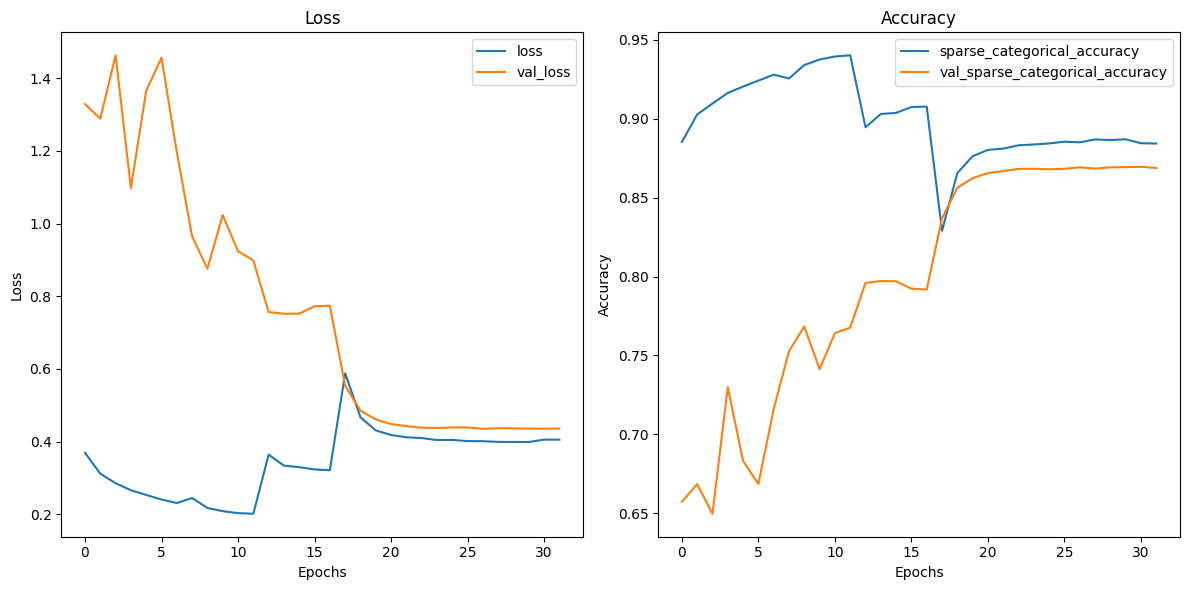

In [ ]:
evaluation.plot_fit_history(history, ['loss', 'val_loss'],['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

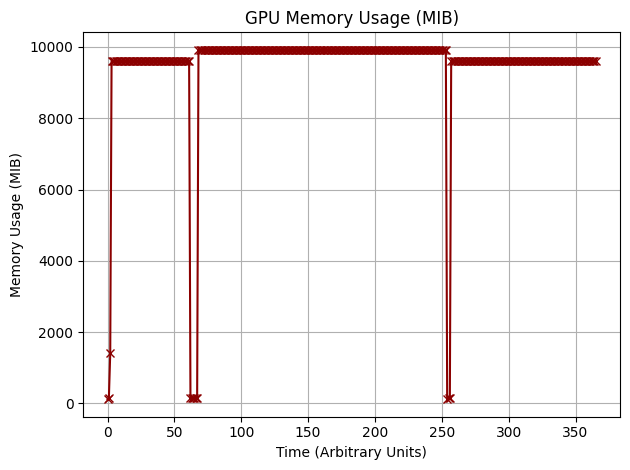

In [ ]:
#get and plot memory usage
df_gpu_train = evaluation.get_gpu_usage(log_file_path)

# Evaluation

Evaluate the Conformer model in terms of its performance on the test dataset, resource consumption (CPU and GPU), and time required for execution and training to be able to compare it with the baseline model.

In [ ]:
#preprocess the test data
test_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))
file_paths_test = tf.constant(test_df['filepath'].values)
labels_test = tf.constant(test_df['mapped_label'].values)
numeric_labels_test = label_lookup(labels_test)
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths_test, numeric_labels_test))

In [ ]:
test_spectrogram_ds = test_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,mfcc=True,noise=True),
                               num_parallel_calls=tf.data.AUTOTUNE)

Padding shape: (16000,)
log_mel_spectrogram shape: (98, 40)
Mfcc shape: (98, 40, 1)


In [ ]:
batch_size = 32
test_spectrogram_ds = test_spectrogram_ds.batch(batch_size)

In [ ]:
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_conformer_model_test.txt'
interval = 10

In [ ]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [ ]:
# generate the predictions
start_time = time.time()
predictions = best_model.predict(test_spectrogram_ds)
end_time = time.time()
cpu_usage_test= psutil.cpu_percent() * 12.7
stop_event.set()
total_time_test = end_time - start_time
print(f"Total testing time: {total_time_test} seconds")

344/344 [==============================] - 16s 44ms/step
Total testing time: 16.193692445755005 seconds


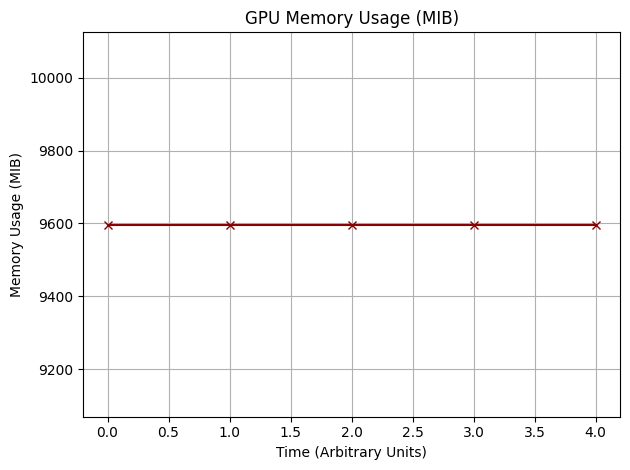

In [ ]:
#get and plot the train memory usage
df_gpu_test = evaluation.get_gpu_usage(log_file_path)

In [ ]:
#get performance metrics
true_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)
metrics_df = evaluation.get_error_metrics("Conformer Model", true_labels, predictions)
metrics_df.head()

,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Conformer Model,0.886727,0.832624,0.849247,0.852612,2.506228


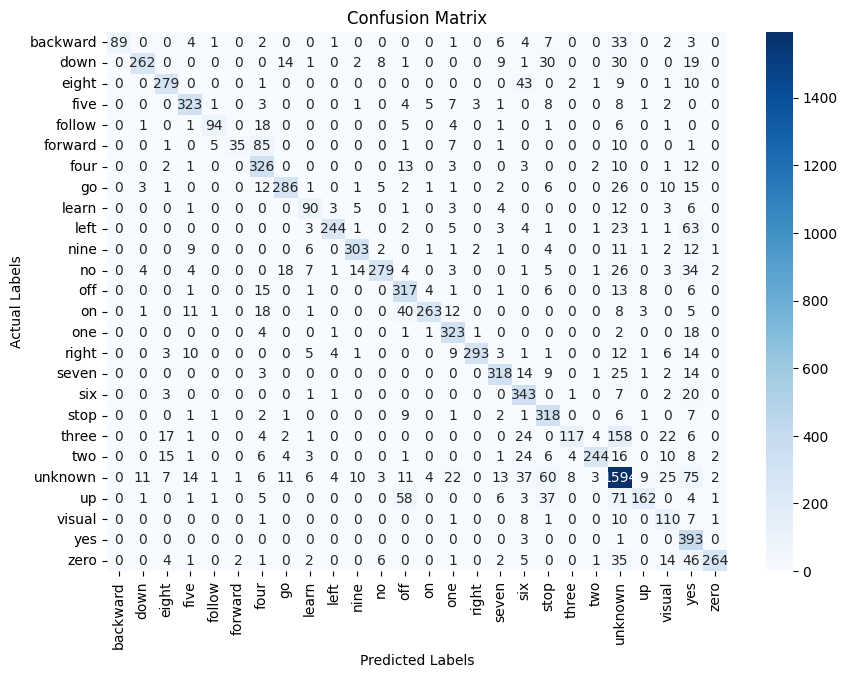

In [ ]:
evaluation.plot_confusion_matrix(true_labels,predictions,label_lookup)

# Summary

In [ ]:
mean_train = df_gpu_train['Memory Usage (MiB)'].mean()
mean_test = df_gpu_test['Memory Usage (MiB)'].mean()
max_train = df_gpu_train['Memory Usage (MiB)'].max()
max_test = df_gpu_test['Memory Usage (MiB)'].max()
total_params = best_model.count_params()

In [ ]:
print(f"Training time: {total_time_train:.3f} seconds")
print(f"Average GPU usage train: {mean_train:.3f} MiB")
print(f"Maximum GPU usage train: {max_train:.3f} MiB")
print(f"CPU usage train: {cpu_usage_train:.3f} GB")

print(f"Testing time: {total_time_test:.3f} seconds")
print(f"Average GPU usage test: {mean_test:.3f} MiB")
print(f"Maximum GPU usage test: {max_test:.3f} MiB")
print(f"CPU usage test: {cpu_usage_test:.3f} GB")

print(f"Number of parameters: {total_params}")

metrics_df.head()

Training time: 3359.828 seconds
Average GPU usage train: 9453.557 MiB
Maximum GPU usage train: 9917.000 MiB
CPU usage train: 3.984 GB
Testing time: 49.468 seconds
Average GPU usage test: 9597.000 MiB
Maximum GPU usage test: 9597.000 MiB
CPU usage test: 3.984 GB
Number of parameters: 1816090


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Conformer Model,0.886727,0.832624,0.849247,0.852612,2.506228


The Conformer model significantly outperforms the baseline model in terms of precision, recall, F1 score, and accuracy. While the training duration is longer due to an increased number of epochs, which substantially enhances accuracy, this extended training period is justified by the model's improved performance metrics. Additionally, the CPU usage and the number of parameters for the Conformer model are lower compared to the baseline model, indicating a more efficient design. However, GPU consumption is notably higher than that of the baseline model, potentially posing challenges for systems dedicated to keyword spotting. This increased GPU usage may partly result from intensive hyperparameter tuning, which was both resource-intensive and time-consuming. Notably, we did not restart the runtime after this process.

For keyword spotting (KWS) systems, it's important to note that hyperparameter tuning and initial model training do not necessarily need to be performed on the device itself; these processes can be completed on a more powerful computer, with only the trained model deployed on the KWS device or accessed by it. The prediction time for the trained dataset was swift, at 44ms/step, which is favorable for KWS applications where minimal latency between the spoken keyword and its detection is crucial.

In conclusion, considering its superior performance and acceptable trade-offs in resource consumption and training time, the Conformer model emerges as the preferable choice over the baseline model for applications in keyword spotting.

# References

**[Gulati20]**

Gulati, A., Qin, J., Chiu, C., Parmar, N., Zhang, Y., Yu, J., Han, W., Wang, S., Zhang, Z., Wu, Y., & Pang, R. (2020). Conformer: Convolution-augmented Transformer for Speech Recognition. ArXiv, abs/2005.08100.